<h2>CNN Image Pattern Recognition</h2>
<h3>Background</h3>
This model relies on technical features which would be utilized by day traders - candlestick charts with moving averages and Bollinger bands. There were 10 stocks, and 2 ETFs that were selected to trade due to their high intraday volume, however the choices were limited due to Alpha Vantage . These stocks and ETFs were NVDA, AMD, JPM, JNJ, MRNA, F, TSLA, MSFT, BAC, BABA, SPY, and QQQ. 

The historical intraday stock values of open, high, low, close were all used to train the model by creating candlesticks every 5 or 15 minute intervals. These larger intervals were chosen, compared to 1 minute or 2 minute intervals, because at the small intervals there were a lot of timestamps which had no volume, meaning no trades and no volatility. The CNN is used as an image pattern recognition model to recognize when the stock will go up or go down given the candlestick charts.

<img alt="https://learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/" height="500" src="assets/cnn.jpg" title="Title" width="500"/>
Above is a CNN model schema example seen <a href="https://learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/">here</a>. The first part consists of Convolutional and max-pooling layers, while the second part consists of the fully connected layer, which performs non-linear transformations of the extracted features and, in this case, acts as the classifier. Two types of outputs here can be either a softmax or a sigmoid layer, which will tell whether the image is of a cat or not, or probabilty of the image being a cat.
<h3>Why a CNN model?</h3>
CNNs are fully connected feed forward neural networks, and are very effective in reducing number of parameters without losing the quality of the model. Since images have a lot of features, with each pixel considered its own feature, they have very high dimensionality. Thus, since CNNs are good at dimension reduction without loss of quality in the model, CNNs are good with images.

In [12]:
import splitfolders
import time
import os
import pickle
import pandas as pd
import requests
import csv
from tqdm import tqdm
import pandas as pd
import mplfinance as mpf
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.models import Sequential
from keras import metrics
from keras import callbacks
from IPython.display import Image
import plotly.express as px

In [13]:
def get_short_stock_info():
    """
    This function outputs all csv files to /assets/historical-symbols/ directory as individual CSV files per stocks
    Will be choosing 10 stocks that make up the top of the S&P500
    """
    symbol_list = ['NVDA', 'AMD', 'JPM', 'JNJ', 'MRNA', 'F', 'TSLA', 'MSFT', 'BAC', 'BABA', 'SPY', 'QQQ']
    # ones that work with alpha vantage (no nasdaq)
    # chosen for high volume and availability on alpha vantage
    av_api_key = os.getenv('ALPHAVANTAGE_API_KEY')
    slices = ['year{}month{}'.format(a, b) for a in range(1, 3) for b in range(1, 13)]
    for ticker in tqdm(symbol_list):
        ticker_df = pd.DataFrame()
        for slice in slices:
            # each request takes approximately 3 seconds
            csv_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=' \
                      '{}&interval=5min&slice={}&apikey={}'.format(ticker, slice, av_api_key)
            new_df = pd.read_csv(csv_url, header=0)
            ticker_df = ticker_df.append(new_df)
        ticker_df.to_csv('assets/short_term_symbols/{}.csv'.format(ticker))
        # sleeps 15 seconds just to make sure no timeout is incurred
        time.sleep(15)
    print("Done!")

In [14]:
# cwd = os.getcwd()
# path = os.path.join(cwd, 'assets/short_term_symbols')
# if not os.path.exists(path):
#     os.mkdir(path)
# get_short_stock_info()

In [15]:
def bollinger_bands(data, sma, window):
    std = data.rolling(window=window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

In [16]:
def create_candles(plot_df, folder, file):
    fig, ax = plt.subplots(figsize=(5, 5))
    mpf.plot(plot_df, type='candlestick', style='charles', ax=ax)
    plot_df.reset_index().plot(kind='line', y='upper_bb', color='blue', lw=3, alpha=0.75, ax=ax, legend=None)
    plot_df.reset_index().plot(kind='line', y='lower_bb', color='orange', lw=3, alpha=0.75, ax=ax, legend=None)
    plot_df.reset_index().plot(kind='line', y='ema12', color='black', lw=3, alpha=0.75, ax=ax, legend=None)
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.axis('off')
    save_spot = f'assets/cnn_images_5m/{folder}/'
    if not os.path.exists(save_spot):
        os.makedirs(save_spot)
    plt.savefig(f'{save_spot}/{file}.png', dpi=50, bbox_inches='tight')
    try:
        plt.close()
    except Exception as e:
        print(e)

In [17]:
def candle_creator(ticker, num_index):
    df = pd.read_csv(f'assets/short_term_symbols/{ticker}.csv').drop(columns=['Unnamed: 0'])
    df = df.reindex(index=df.index[::-1])
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index(df['time']).drop(columns=['time'])
    df = df.resample('5min').first()
    df[['open', 'high', 'low', 'close']] = df[['open', 'high', 'low', 'close']].ffill()
    df['volume'] = df['volume'].fillna(0)
    df['MA12'] = df['close'].rolling(window=12).mean()
    df['upper_bb'], df['lower_bb'] = bollinger_bands(df['close'], df['MA12'], 12)
    df['ema12'] = df['close'].ewm(span=12).mean()
    df = df[(df.index < '2020-07-19')]
    df = df.iloc[11:]
    # doing every 30m intervals
    for start in range(0, df.shape[0], 6):
        data = df.iloc[start:start + num_index].copy()
        # when a quarter the data is filled in skip for training purpose
        last_point = data[['open', 'high', 'low', 'close']].iloc[0].mean()
        next_points = [last_point]
        # checks if next point has volume then creates chart
        next_row = df.iloc[start+1]
        same_day = next_row.name.hour > 4
        if next_row['volume'] > 0.0 and same_day:
            next_points.append(next_row[['open', 'high', 'low', 'close']].mean())
            if next_points[1] > next_points[0]:
                folder = 'buy'
            else:
                folder = 'hold'

            file = ticker + '_' + str(start)
            if 0.0 in data['volume'].value_counts():
                if data['volume'].value_counts()[0.0] <= 4:
                    create_candles(data, folder, file)
            else:
                create_candles(data, folder, file)

In [18]:
# symbol_list = ['NVDA', 'AMD', 'JPM', 'JNJ', 'MRNA', 'F', 'TSLA', 'MSFT', 'BAC', 'BABA', 'SPY', 'QQQ']
# if not os.path.exists('assets/cnn_images_5m'):
#     os.makedirs('assets/cnn_images_5m')
# for symbol in tqdm(symbol_list):
#     try:
#         candle_creator(ticker=symbol, num_index=12)
#     except Exception as e:
#         print(e)

Two classes are used here, buy and don't buy. In this situation, the image below is a 'buy' signal.
After creating these images comes training the CNN, which is seen below in the `train_cnn_model` function. This is a sample model with modified parameters in order to run quickly, as this was ran using `short_cnn.py` file instead.

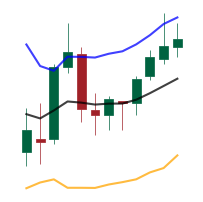

In [19]:
Image(filename='assets/cnn_images_5m/buy/AMD_342.png')

In [20]:
def train_cnn_model(width, height, num_samples, needs_split=False):
    """
    This trains a cnn model and outputs the model to the specified location below
    :param width: width of image
    :param height: height of image
    :param num_samples: total number of samples that are being split
    :param needs_split: if the samples are split into the output folder or not
    """
    start = time.time()
    if needs_split:
        splitfolders.ratio("assets/cnn_images_5m/", output="assets/cnn_images_5m/output",
                           seed=0, ratio=(0.8, 0.1, 0.1), group_prefix=None)

    model_metrics = ['accuracy', metrics.BinaryCrossentropy(), metrics.Precision(),
                     metrics.Recall(), metrics.BinaryAccuracy()]
    img_width, img_height = width, height
    train_data_dir = 'assets/cnn_images_5m/output/train'
    val_data_dir = 'assets/cnn_images_5m/output/val'
    test_data_dir = 'assets/cnn_images_5m/output/test'
    epochs = 10
    batch_size = 32
    validation_steps = 6494 // batch_size # number of validation samples available
    classes_num = 2
    nb_filters1 = 16
    nb_filters2 = 32
    conv1_size = 4
    conv2_size = 2
    pool_size = 2

    model = Sequential()
    model.add(Convolution2D(nb_filters1, conv1_size, conv1_size, input_shape=(img_width, img_height, 3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(Convolution2D(nb_filters2, conv2_size, conv2_size))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation("relu"))
    model.add(Dropout(0.5))
    model.add(Dense(classes_num, activation='softmax'))

    model.summary()
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=model_metrics)

    train_datagen = ImageDataGenerator()
    test_datagen = ImageDataGenerator()
    
    # buy is 0, hold is 1
    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    log_dir = './tf-log/'
    tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
    cbks = [tb_cb]

    history = model.fit(
        train_generator,
        batch_size=batch_size,
        steps_per_epoch=num_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=cbks,
        validation_steps=validation_steps)

    target_dir = './models/'
    if not os.path.exists(target_dir):
        os.mkdir(target_dir)
    model.save(f'assets/models/joey_cnn_intraday/cnn_model_5m_{epochs}epochs_{classes_num}classes.h5')
    model.save_weights(f'assets/models/joey_cnn_intraday/cnn_weights_5m_{epochs}epochs_{classes_num}classes.h5')

    with open(f'assets/models/joey_cnn_intraday/history_5m_{epochs}epochs_{classes_num}classes.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    # Calculate execution time
    end = time.time()
    dur = end - start

    if dur < 60:
        print("Execution Time:", dur, "seconds")
    elif 60 < dur < 3600:
        dur = dur / 60
        print("Execution Time:", dur, "minutes")
    else:
        dur = dur / (60 * 60)
        print("Execution Time:", dur, "hours")

In [21]:
needs_split = True
if os.path.exists('assets/cnn_images_5m/output'):
    needs_split = False
train_cnn_model(width=203, height=202, num_samples=51957, needs_split=needs_split)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 50, 50, 16)        784       
_________________________________________________________________
activation_3 (Activation)    (None, 50, 50, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        2080      
_________________________________________________________________
activation_4 (Activation)    (None, 12, 12, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [22]:
px.scatter(pickle.load(open('assets/models/joey_cnn_intraday/history_5m_25epochs_2classes.pkl', 'rb'))['loss'])